In [1]:
import h5py as h5
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import sys
import optuna
from sklearn.model_selection import ParameterGrid
#sys.path.append('/projects/EKOLEMEN/survival_tm/train_models/auton-survival')
sys.path.append(os.path.expanduser("~/TMPredictor/survival_tm/auton-survival"))
from sklearn.model_selection import ParameterGrid
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from auton_survival.models.dsm import DeepSurvivalMachines
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

/home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
shots = np.load('/projects/EKOLEMEN/survival_tm/shots.npy')
tm_shots = np.load('/projects/EKOLEMEN/survival_tm/tm_shots.npy')
st_shots = np.load('/projects/EKOLEMEN/survival_tm/st_shots.npy')

In [6]:
def load_data(data_type):
    with open(f'/projects/EKOLEMEN/survival_tm/formatted_labels/{data_type}.pkl', 'rb') as f:
        data = pickle.load(f)
    
    return data['x'], data['t'], data['e']

In [7]:
# Don't want whole dataset right now so 0.5 factor to reduce
n = len(shots)

tr_size = int(n*0.80)
vl_size = int(n*0.10)
te_size = int(n*0.10)

train_shots = shots[:tr_size]
test_shots = shots[-te_size:]
valid_shots = shots[tr_size:tr_size+vl_size]

x_train, t_train, e_train = load_data('train')
x_test,  t_test,  e_test  = load_data('test')
x_valid, t_valid, e_valid = load_data('valid')

index = 100190
print(t_test[index:index+100])
print(e_test[index:index+100])

# Get inds for time <600ms
inds = np.where(t_train < 600)[0]

x_train = x_train[inds]
t_train = t_train[inds]
e_train = e_train[inds]

tm_inds = np.where(e_train == 1)[0]
st_inds = np.where(e_train == 0)[0]
new_st_inds = np.random.choice(st_inds, size=len(tm_inds), replace=False)

x_train = np.concatenate((x_train[tm_inds], x_train[new_st_inds]), axis=0)
t_train = np.concatenate((t_train[tm_inds], t_train[new_st_inds]), axis=0)
e_train = np.concatenate((e_train[tm_inds], e_train[new_st_inds]), axis=0)

# Shuffle arrays because currently all 1s followed by all 0s
p = np.random.permutation(len(t_train))
x_train = x_train[p,:]
t_train = t_train[p]
e_train = e_train[p]
print(x_train.shape)


[1380 1360 1340 1320 1280 1260 1240 1220 1180 1160 1140 1120 1080 1060
 1040 1020  980  960  940  920  880  860  840  820  780  760  740  720
  680  660  640  620  580  560  540  520  480  460  440  420  380  360
  340  320  280  260  240  220 2160 2140 2120 2100 2080 2060 1080 1060
 1040 1020   80   60   40   20 2120 2100 2080 2060 1120 1100 1080 1060
   80   60 2140 2120 2100 2080 1140 1120 1100 1080  140  120  100   80
 2080 2060 2040 2020 1080 1060 1040 1020   80   60   40   20  900 1040
 1020 1000]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(116950, 179)


In [8]:
param_grid = {'k' : [2, 4, 6, 8],
              'distribution' : ['LogNormal', 'Weibull'],
              'learning_rate' : [ 1e-5, 1e-4, 1e-3 ],
              'activation': ['ReLU6', 'ReLU', 'SeLU', 'Tanh'],
              'lin1' : [50, 100, 150],
              'lin2' : [30, 40, 50, 60],
              'lin3' : [50, 100, 150],
              'lin4' : [50, 100, 150],
              'lin5' : [50, 100, 150],
             }

param_grid = {'k' : [3],
              'distribution' : ['LogNormal'],
              'learning_rate' : [ 0.00392 ],
              'activation': ['SeLU'],
              'lin1' : [100],
              'lin2' : [60],
              'lin3' : [175],
              'lin4' : [225],
              'lin5' : [120],
             }

layers = dict()
layers['lin1'] = param_grid['lin1']
layers['lin2'] = param_grid['lin2']
layers['lin3'] = param_grid['lin3']
layers['lin4'] = param_grid['lin4']
layers['lin5'] = param_grid['lin5']
params = ParameterGrid(param_grid)

In [9]:
import torch
models = []
x_train_df = pd.DataFrame(x_train)
t_train_df = pd.DataFrame(t_train)
e_train_df = pd.DataFrame(e_train)
outcomes_df = pd.DataFrame({'time': t_train, 'event': e_train})
layers = [100, 60, 175, 225, 120]
model = SurvivalModel(model='dsm', iters=1, k=3, layers=layers, distribution='LogNormal',learning_rate=1e-3, batch_size=10000)
model.fit(x_train_df, outcomes_df)
torch.save(model.state_dict(), 'model.pth')
model.save('model.pkl')
'''for param in params:
    model = SurvivalModel(model='dsm')
    # The fit method is called to train the model
    model.fit(x_train_df, outcomes_df)
    models.append([[model.compute_nll(x_valid, t_valid, e_valid), model]])
best_model = min(models)
model = best_model[0][1]'''

[[9.84220312e+03 7.92502356e+00 2.02168250e+00 ... 5.03491354e+00
  5.60739899e+00 8.01995659e+00]
 [8.37571289e+02 7.81860769e-01 1.60473633e+00 ... 3.96509671e+00
  4.49912739e+00 6.88696814e+00]
 [8.20828809e+03 6.75994730e+00 3.31544280e+00 ... 6.15120745e+00
  6.71863317e+00 9.71392536e+00]
 ...
 [5.31827344e+03 4.72652054e+00 1.85789073e+00 ... 3.43014956e+00
  3.92210197e+00 5.89965439e+00]
 [2.80900732e+03 1.53925145e+00 1.89470637e+00 ... 3.00512052e+00
  3.39057112e+00 5.53603458e+00]
 [5.04365771e+03 4.23312187e+00 1.94402063e+00 ... 3.12370872e+00
  3.55447054e+00 5.93435097e+00]]


  3%|▎         | 309/10000 [00:06<03:21, 48.00it/s]


KeyboardInterrupt: 

In [39]:
times = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
with open('survival.pkl', 'rb') as f:
    out_survival = pickle.load(f)

#out_risk = model.predict_risk(pd.DataFrame(x_test), times)
#out_survival = model.predict_survival(pd.DataFrame(x_test), times)

In [11]:
#outcomes_train=pd.DataFrame({'time': t_train, 'event': e_train})
outcomes_test=pd.DataFrame({'time': t_test, 'event': e_test})
score = survival_regression_metric(metric='auc', outcomes=outcomes_test, predictions=out_survival, times=times)

/home/hf8585/TMPredictor/survival_tm/auton-survival/auton_survival/metrics.py:212: UserWarning: You are are evaluating model performance on the same data used to estimate the censoring distribution.
  warnings.warn("You are are evaluating model performance on the \


Text(0, 0.5, 'AUROC')

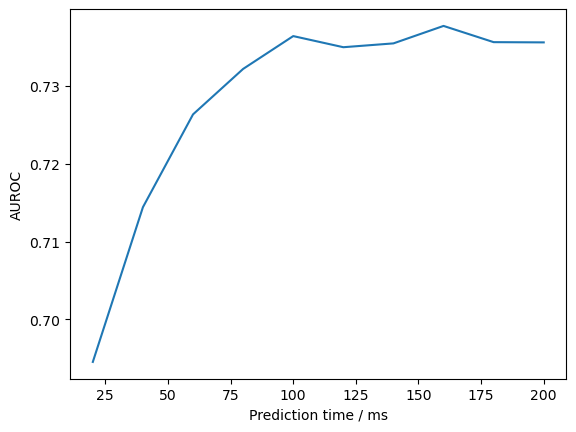

In [47]:
plt.plot(times, score)
plt.xlabel('Prediction time / ms')
plt.ylabel('AUROC')

In [12]:
def find_peaks_in_data(data):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i-1] < data[i] > data[i+1]:
            peaks.append(i)
    return peaks
peaks = find_peaks_in_data(t_test)



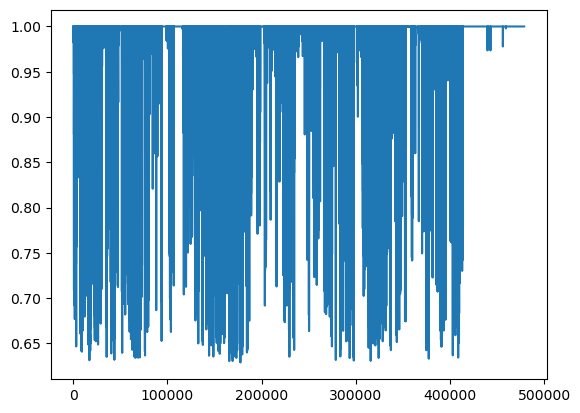

In [13]:
plt.plot(out_survival[:, 6])

In [ ]:
for i in range(0, 10):
    peak_number = 250 + i
    start_index = peaks[peak_number]
    end_index = peaks[peak_number + 1]
    times = np.arange(0, (end_index - start_index)*20, 20)
    plt.plot(times, out_survival[start_index:end_index,4], label='Survival in 100ms')
    plt.plot(times, out_survival[start_index:end_index,9], label='Survival in 200ms')

    if (e_test[start_index]==1):
        plt.title('Shot with TM')
    else:
        plt.title('Shot without TM')
    plt.xlabel('Time / ms')
    plt.ylabel('Survival probability')
    plt.legend()
    plt.show()

Text(0, 0.5, 'Prediction time / ms')

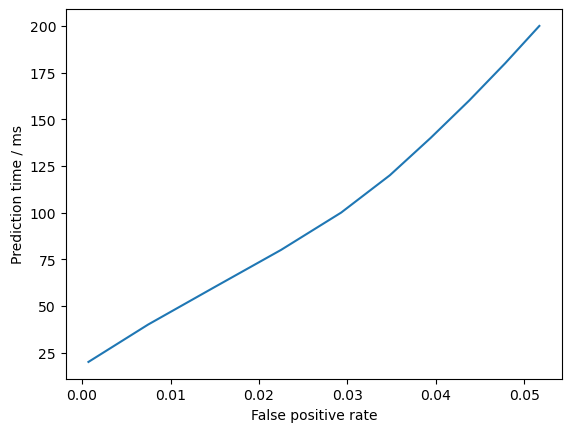

In [42]:
# make WTC curve

# one issue with this metric is if we never predict TMs then we're always perfect. 
fpr_list = []

for i in range(len(times)):
    threshold = 0.9
    survival_probabilities = out_survival[:,i]
    # Prediction that the event will occur
    predictions = (survival_probabilities < threshold).astype(int)
    true_labels = e_test
    # Calculate False Positives
    false_positives = np.logical_and(predictions == 1, true_labels == 0)

    # Calculate True Negatives
    true_negatives = np.logical_and(predictions == 0, true_labels == 0)

    # Calculate FPR
    fpr = false_positives.sum() / (false_positives.sum() + true_negatives.sum())
    fpr_list.append(fpr)

plt.plot(fpr_list, times)
plt.xlabel('False positive rate')
plt.ylabel('Prediction time / ms')

In [ ]:
fnr_list = []

# these need to be calculated only at time t before the event occurst, so one datapoint per shot. 
for i in range(len(times)):
    threshold = 0.5
    survival_probabilities = out_survival[:,i]
    # Prediction that the event will occur
    predictions = (survival_probabilities < threshold).astype(int)
    true_labels = e_test
    # Calculate False Negative
    false_negatives = np.logical_and(predictions == 0, true_labels == 1)

    # Calculate True Negatives
    true_positives = np.logical_and(predictions == 1, true_labels == 1)

    # Calculate FPR
    fpr = false_positives.sum() / (false_positives.sum() + true_negatives.sum())
    fpr_list.append(fpr)

plt.plot(fpr_list, times)